# 096222 Problem Set 4

This executable notebook will guide you through Problem Set 4. We'll use an RNN model (that we previously trained) to perform several rounds of targeted syntactic evaluation:

- In **Task 0**, we'll introduce the basic structure of our targeted syntactic evaluation framework.
- **Task 1** will present a partially completed experiment, which we'll ask you to improve and extend.
- **Task 2** will ask you to design your own experiment from scratch, drawing on any of a number of recommended interesting syntactic phenomena.

A few Colab-specific reminders:

- Google offers free compute (including GPU compute!) on this notebook, but only for a limited time. Your session will be automatically closed after 12 hours. That means you'll want to finish within 12 hours of starting, or make sure to save your intermediate work so that you can resume on a fresh notebook instance later.
- As in Problem Set 3, we'll read and write all important data to your Google Drive.

# Getting started

**First**, make a copy of this notebook so you can make your own changes. Click *File -> Save a copy in Drive*.

### What you need to do

Read through this notebook and execute each cell in sequence, making modifications and adding code where necessary. You should execute all of the code as instructed, and make sure to write code or textual responses wherever the text **TODO** shows up in text and code cells.

When you're finished, convert the notebook to PDF by running the last cell. You will upload this `PDF` file as your submission.

OK, let's go!

## Workspace setup

In [ ]:
# Interactive tables
%load_ext google.colab.data_table

In [ ]:
import ast
from collections import defaultdict
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import sys

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
import pandas as pd

import logging
logging.basicConfig(level=logging.DEBUG)
L = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.WARNING) # Hide matplotlib inner logs

## Set up dependencies and data

Run the cell below to fetch the recurrent neural network codebase we've designed for this assignment. It will leave the files in a directory called `rnn` (check in the sidebar after you've run the command).

For those that chose project 1 - the `rnn` folder is similar to the one that you are using in the project. That is as we train the recurrent model with that same code.

In [ ]:
%%bash
git clone --branch 096222 https://github.com/lacclab/neural-complexity.git rnn
mkdir -p rnn/data/ptb

Cloning into 'rnn'...


In [ ]:
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Mount Google Drive

We'll save model results on test suites to Google Drive for safekeeping. Follow the instructions in the output of this command to link your Drive account.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
WORK_PATH = "/content/gdrive/My Drive/096222-pset4"
GDRIVE_DIR = WORK_PATH

!mkdir -p "$GDRIVE_DIR"
!mkdir -p "$GDRIVE_DIR/corpus_data"

### Mount shared data and code

!!!
<mark> Next, manually add [this shared folder](https://drive.google.com/drive/folders/1QLiC8NWVI3MINzFnbOUcE4nDOb8woYvV?usp=sharing) to your Google Drive at the path *096222-pset4* !!!  

To add the folder: Press on the above link, right click on the `Shared resources` folder, press on `Organize`, then on `Add shortcut`, then on `My drive` and on `096222-pset4`


After you've done this, run the cell below to set relevant variables.

In [ ]:
RESOURCE_PATH = f"{WORK_PATH}/Shared resources"
VOCAB_PATH = f"{RESOURCE_PATH}/ptb_vocab.txt"
OLD_MODEL_CHECKPOINT = f"{RESOURCE_PATH}/ptb_model.pt" # Not in use
MODEL_CHECKPOINT = f"{RESOURCE_PATH}/ptb_model-40.pt" # Updated model

In [ ]:
if not Path(RESOURCE_PATH).exists():
  raise RuntimeError("Please mount the shared folder to your Google Drive before "
                     "continuing. See instructions directly above this cell.")

In [ ]:
sys.path.append(RESOURCE_PATH)
import pipeline

In [ ]:
!mkdir -p "$WORK_PATH/suites"

## Task 0: Reduced relative clause ambiguity

We'll introduce our targeted syntactic evaluation pipeline by using it to study the familiar processing phenomenon of **garden-pathing**. Recall from class the following examples of sentences which, until the critical word in bold, are ambiguous between two structural interpretations:

1. The horse raced past the barn **fell**.
2. The woman brought the sandwich **tripped**.

Before the appearance of the second verb in bold above, the sentence prefixes are ambiguous between a "main verb" (MV) interpretation, where the horse and woman are involved in the main event of the sentence, and a "reduced relative" (RR) interpretation".

There are two small changes we can make to these sentences to change the amount of evidence for the MV and RR interpretations:

1. **reduction**: we can insert an overt relativizer to clearly signal the relative clause case:<blockquote>The woman *who was* brought the sandwich tripped.</blockquote>We'll call sentences without relativizers "reduced," and sentences with relativizers "unreduced." Unreduced sentences unambiguously signal that the prefix should be interpreted as RR and not MV.
2. **verb ambiguity**: this ambiguity between RR and MV only arises when the first verb has identical past participle and simple past forms. As reviewed in class, verbs without this property don't create the ambiguity:<blockquote>The woman *given* the sandwich tripped. *(unambiguous RR)*<br/>The woman *gave* the sandwich to the boy. *(unambiguous MV)*</blockquote>

In this first task, we'll operationalize these linguistic facts as predictions about online language processing. We'll design and build the first of several *test suites*: descriptions of psycholinguistic experiments which we can apply to our computational models.

### The basic structure of a test suite

<img src="https://imgur.com/c1j4fsb.png">

The above figure shows the structure of the test suite we'll use for analyzing reduced relative clause garden pathing.

<!--The big question we are interested in asking is: What have neural LMs learned about human language? In order to do this we are going to compare the outputs of the models to human behavior. Specifically, we are going to look at the difference between grammatical and ungrammatical sentences, with the idea that good language models should assign higher probability to grammatical sentences than their minimal-pair ungrammatical counterparts.

In order to assess what the language models have learned about grammar, we are going to test them on a number of <b> test suites </b> where each test suite is designed to probe knowledge about one particular element of the grammar.-->

#### Items, conditions, regions

Test suites are composed of <i> items </i>, which are groups of related sentences that we aim to test on the model. Each item has a number of <i> conditions </i>, with one sentence per condition. In this case, we have four conditions for each of the possible combinations of `{ambiguous verb, unambiguous verb} * {reduced prefix, unreduced prefix}`, using the terms introduced earlier.

We divide each sentence into *regions*, and we'll measure how model surprisals compare within these regions across different conditions. For this test suite, we're interested in language models' surprisal estimates in the `disambiguator` region, where the second verb appears.

#### Predictions

Test suites are designed with a hypothesis in mind: if a model has correctly learned some relevant syntactic generalization, then it should assign higher probability to grammatical continuations of sentences. Correspondingly, test suite <i> predictions </i> operationalize these hypotheses as expected inequalities between total model surprisal values in different experimental conditions.

In our case, we can make relatively fine-grained predictions about the way a model should process these MV/RR sentences. First, we can make two basic "first-order" predictions:

1. In **reduced** constructions, language models should be surprised when encountering the second verb (relative to **unreduced** constructions).
2. In constructions with **ambiguous** initial verbs, language models should be surprised when encountering the second verb (relative to **unambiguous** verb constructions).

We'll operationalize these predictions as formulas relating region-level surprisals across conditions. We'll rewrite the previous predictions as machine-readable Boolean expressions. We reference the surprisal values of particular regions using the syntax `(region_i;%condition%)`, where `region_i` is the 1-indexed region number and `condition` is the name of the relevant condition.

1. <pre>[(5;%reduced_ambig%) > (5;%unreduced_ambig%)] & [(5;%reduced_unambig%) > (5;%unreduced_unambig%)]</pre>
2. <pre>[(5;%reduced_ambig%) > (5;%reduced_unambig%)] & [(5;%unreduced_ambig%) > (5;%unreduced_unambig%)]</pre>

Note that each of the clauses in this boolean relates regions across just two conditions. We can also say something stronger about the relation between different sentence types in this test suite. Because the use of an unambiguous verb leaves no uncertainty about whether a prefix licenses an MV or RR interpretation, we can confidently say that the effect of including a relativizer *who* should be stronger only when the first verb is ambiguous:

3. <pre>[[(5;%reduced_ambig%) - (5;%unreduced_ambig%)] > [(5;%reduced_unambig%) - (5;%unreduced_unambig%)]]</pre>

<b> Advanced note: </b> for more information about the format of prediction formulas, please see the [SyntaxGym documentation](http://docs.syntaxgym.org).

<!--
To see a concrete example of a test suite, take a look at the figure below. Here, conditions are shown as colored pill shapes, regions are shown as columns, and items are shown as groups of rows. The prediction is actually a conjunction of multiple inequalities that should hold between the rows within item blocks.-->

### The test suite CSV format

We'll now represent the above knowledge in a CSV (comma-separated value format).

Run the code block below to see the beginning of our test suite.
In this file, we store predictions as comments at the top of the file, labeled with the content `#Prediction`.

Next, a header row describes the relevant regions of this test suite. The subsequent rows form the body of the test suite, with one row per sentence. The first column specifies the item number, the second column specifies the condition name, and the rest of the columns specify sentence regions. (If the CSV formula is difficult to visualize, feel free to save this in a `.csv` file and open with your favorite spreadsheet editor, which will put things in nicely aligned columns for you!)

<!--
Sentence regions and conditions are used to write <b> prediction formulas </b>. Following example 8 in the homework, we predict that the difference in surprisal in the region `to the bill` is greater  for the contexts `accepted..`/`accepted that...` than for the contexts `believed`/`believed that...` because `accepted` is more likely to take an NP compliment than `believed`.

In order to make this prediction explicit, let's use a formulation of the test suite below. We are interested in the surprisal in region 5 (e.g. `to the bill` in item 1). Following the logic from equation (1) in the homework, we stipulate success conditions:

<i> [S(Region 5 in the unreduced_do) - S(Region 5 in reduced_do) ] > [ S(Region 5 in unreduced_sc) - S(Region 5 in reduced_sc) ] </i>

We'll shorten this into a machine-readable syntax where the region number and condition are separated by a `;` and the condition name is surrounded by `%`:

```
(5;%unreduced_do%) - (5;%reduced_do%) > (5;%unreduced_sc%) - (5;%reduced_sc%)
```-->

Great! You should now know everything you need to start running and analyzing test suites.

In [ ]:
!head -n15 "$RESOURCE_PATH/suites/mvrr.csv"

#Reference,"Futrell, R., Wilcox, E., Morita, T., Qian, P., Ballesteros, M., & Levy, R. (2019). Neural language models as psycholinguistic subjects: Representations of syntactic state."
#Prediction,[(5;%reduced_ambig%) > (5;%unreduced_ambig%)]
#Prediction,[(5;%reduced_ambig%) > (5;%reduced_unambig%)]
#Prediction,[[(5;%reduced_ambig%) - (5;%unreduced_ambig%)] > [(5;%reduced_unambig%) - (5;%unreduced_unambig%)]]
item,condition,Start,Noun,Ambiguous verb,RC contents,Disambiguator,End
1,reduced_ambig,The,woman,brought,the sandwich from the kitchen,fell,in the dining room
1,unreduced_ambig,The,woman,who was brought,the sandwich from the kitchen,fell,in the dining room
1,reduced_unambig,The,woman,given,the sandwich from the kitchen,fell,in the dining room
1,unreduced_unambig,The,woman,who was given,the sandwich from the kitchen,fell,in the dining room
2,reduced_ambig,The,convict,walked,into the dark cell,tried,to escape but failed
2,unreduced_ambig,The,convict,who was walked,into the dark cell

This notebook provides a module named `pipeline`, which contains various functions for running and analyzing syntactic test suites.

We'll first run `pipeline.evaluate_suite`, which takes a CSV specification as shown above, presents each sentence to a language models, and returns a very detailed report about a language model's prediction behavior on the test suite sentences.

In [ ]:
help(pipeline.evaluate_suite)

Help on function evaluate_suite in module pipeline:

evaluate_suite(name, suite_csv, model_checkpoint, work_path, vocab_path, resources_path)
    Given a CSV description of a test suite, evaluate it using a trained
    RNN model and the SyntaxGym pipeline:
    
    1. Convert the CSV file to a SyntaxGym JSON spec;
    2. Extract raw sentences for language model surprisal evaluation;
    3. Unkify those sentences to avoid out-of-vocabulary errors in surprisal evaluation;
    4. Run the RNN model and capture surprisal data;
    5. Integrate this surprisal data back into the SyntaxGym JSON file.
    
    Returns:
      suite_json: A fully evaluated test suite JSON file containing surprisals
        for every region.



In [ ]:
with open(f"{RESOURCE_PATH}/suites/mvrr.csv", "r") as suite_f:
  suite_csv = suite_f.read()
suite_json = pipeline.evaluate_suite("mvrr", suite_csv,
                                     model_checkpoint=MODEL_CHECKPOINT,
                                     work_path=WORK_PATH,
                                     resources_path=RESOURCE_PATH,
                                     vocab_path=VOCAB_PATH)

If the above code cell fails - make sure your runtime type does !not! include a GPU, and try again. (`Runtime`-->`Change runtime type`)

### Visualizing the suite results

A second function, `suite_json_to_df`, will nicely summarize this data as a Pandas dataframe. We'll visualize results for the first experimental item below, with one row per region. A few notes on the most important columns:

1. `content` denotes the original string content of the region.
2. `surprisal` denotes the model's total surprisal for the tokens in this region. Formally, this quantity is $$-\log_2 \prod_i P(w_i \mid w_1, w_2, \dots, w_{i-1}) = \sum_i -\log_2 P(w_i \mid w_1, w_2, \dots, w_{i-1}) = \sum_i S(w_i)$$
3. `oovs` is a list of tokens in the region which were not in the model's vocabulary. We designed this test suite to only test tokens in the model's vocabulary, and you should do the same for your own work later in this notebook.

In [ ]:
# View the results for the first experimental item
suite_df = pipeline.suite_json_to_df(suite_json)
suite_df.loc[1]

content  surprisal  \
condition_name    region_number                                             
reduced_ambig     1                                        The   2.001944   
                  2                                      woman  14.803336   
                  3                                    brought   8.600166   
                  4              the sandwich from the kitchen  39.820854   
                  5                                       fell  17.175095   
                  6                         in the dining room  31.825383   
unreduced_ambig   1                                        The   2.001944   
                  2                                      woman  14.803336   
                  3                            who was brought  22.811825   
                  4              the sandwich from the kitchen  41.328524   
                  5                                       fell  16.396236   
                  6                         in the dining room  31.518349   
reduced_unambig   1                                        The   2.001944   
                  2                                      woman  14.803336   
                  3                                      given  12.798063   
                  4              the sandwich from the kitchen  41.662401   
                  5                                       fell  16.619329   
                  6                         in the dining room  31.611486   
unreduced_unambig 1                                        The   2.001944   
                  2                                      woman  14.803336   
                  3                              who was given  23.324862   
                  4              the sandwich from the kitchen  40.358506   
                  5                                       fell  16.648726   
                  6                         in the dining room  31.720552   

                                oovs     region_name  has_oovs  
condition_name    region_number                                 
reduced_ambig     1               []           Start     False  
                  2               []            Noun     False  
                  3               []  Ambiguous verb     False  
                  4               []     RC contents     False  
                  5               []   Disambiguator     False  
                  6               []             End     False  
unreduced_ambig   1               []           Start     False  
                  2               []            Noun     False  
                  3               []  Ambiguous verb     False  
                  4               []     RC contents     False  
                  5               []   Disambiguator     False  
                  6               []             End     False  
reduced_unambig   1               []           Start     False  
                  2               []            Noun     False  
                  3               []  Ambiguous verb     False  
                  4               []     RC contents     False  
                  5               []   Disambiguator     False  
                  6               []             End     False  
unreduced_unambig 1               []           Start     False  
                  2               []            Noun     False  
                  3               []  Ambiguous verb     False  
                  4               []     RC contents     False  
                  5               []   Disambiguator     False  
                  6               []             End     False

Now, let's visualize the results!

First, we generate a barplot, where the x-axis corresponds to regions, the y-axis corresponds to summed surprisal in each region, and the bars are colored according to sentence condition. Note that these surprisal values are averaged across items.

Text(0.5, 1.0, 'Surprisals per region and condition')

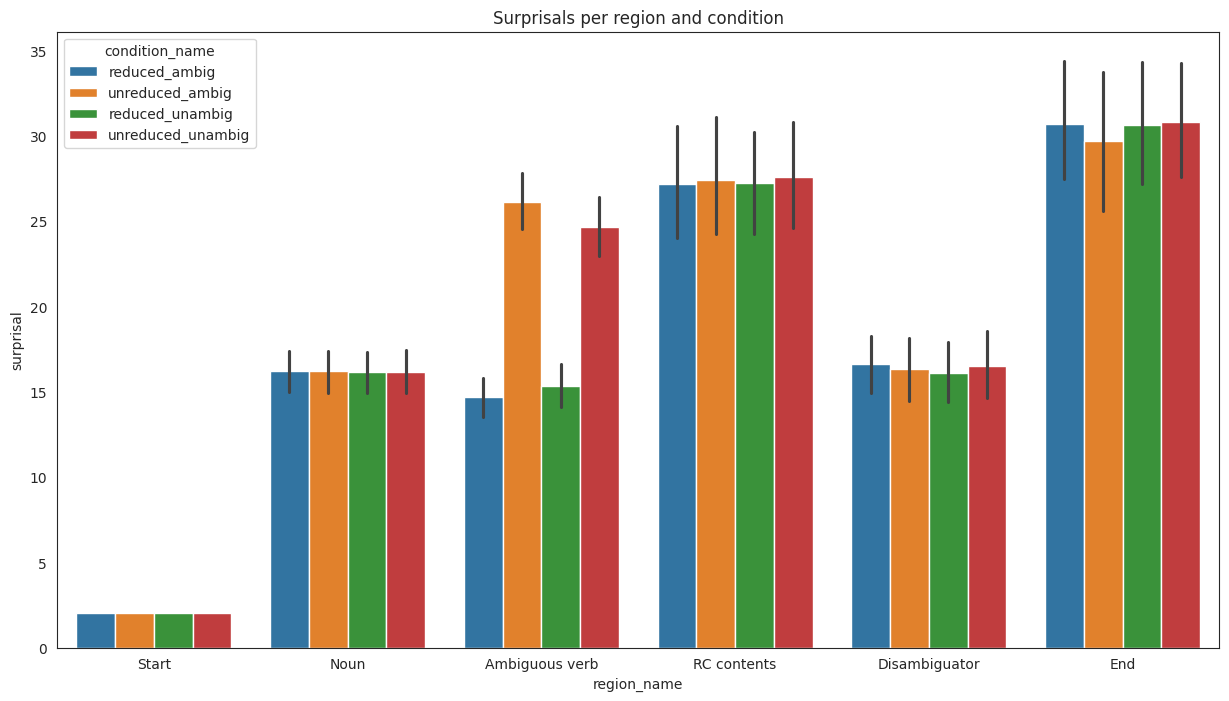

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=suite_df.reset_index(), x="region_name", y="surprisal",
            hue="condition_name", ax=ax)
plt.title("Surprisals per region and condition")

### Evaluating the suite predictions

Based on the test suite prediction and model surprisal outputs, let's evaluate the accuracy of the model. We'll use another helper function, `pipeline.evaluate_predictions`, to check the rate of success of these predictions in the experimental data.

In [ ]:
help(pipeline.evaluate_predictions)

Help on function evaluate_predictions in module pipeline:

evaluate_predictions(suite, custom_predictions=None)
    Compute prediction accuracies for a fully evaluated suite object.
    
    Args:
      suite: fully evaluated suite object
      custom_predictions: Optional list of additional string formulae. These
        predictions will be numbered starting after the final original prediction
        of the test suite in the return data.
    
    Returns:
      prediction_results: A dict mapping <item number> -> <prediction number> -> <correct>
      prediction_accuracies: A dict mapping <prediction number> -> <accuracy>



In [ ]:
prediction_results, prediction_accuracies = pipeline.evaluate_predictions(suite_json)
print("Complete suite results: (dict is <item number> -> <prediction number> -> <correct>")
pprint(prediction_results)

print("\nPrediction accuracies:")
pprint(prediction_accuracies)

Complete suite results: (dict is <item number> -> <prediction number> -> <correct>
defaultdict(<class 'dict'>,
            {1: {0: True, 1: True, 2: True},
             2: {0: False, 1: True, 2: True},
             3: {0: False, 1: False, 2: False},
             4: {0: True, 1: False, 2: True},
             5: {0: False, 1: False, 2: False},
             6: {0: True, 1: True, 2: True},
             7: {0: True, 1: False, 2: True},
             8: {0: True, 1: False, 2: True},
             9: {0: True, 1: True, 2: True},
             10: {0: False, 1: True, 2: False},
             11: {0: True, 1: True, 2: True},
             12: {0: False, 1: False, 2: False},
             13: {0: True, 1: True, 2: False},
             14: {0: True, 1: True, 2: True},
             15: {0: True, 1: True, 2: True},
             16: {0: True, 1: True, 2: True},
             17: {0: True, 1: True, 2: True},
             18: {0: False, 1: False, 2: True},
             19: {0: False, 1: False, 2: True},
    

               mean    median
ambiguous                    
False      0.366307  0.182447
True      -0.240480 -0.383332


Text(0.5, 0, 'Ambiguous verb?')

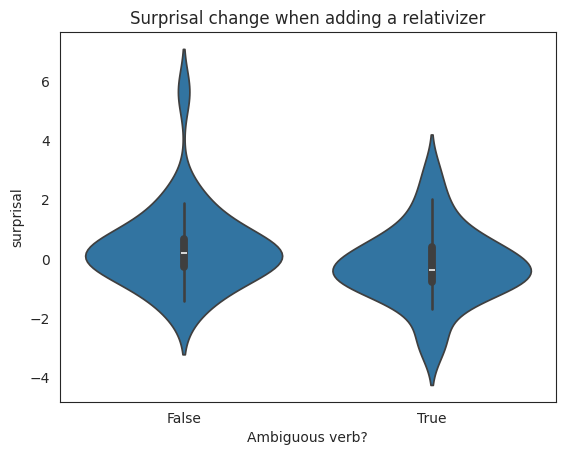

In [ ]:
diffs_ambig = suite_df.xs(("unreduced_ambig", 5), level=("condition_name", "region_number")).surprisal - \
  suite_df.xs(("reduced_ambig", 5), level=("condition_name", "region_number")).surprisal
diffs_unambig = suite_df.xs(("unreduced_unambig", 5), level=("condition_name", "region_number")).surprisal - \
  suite_df.xs(("reduced_unambig", 5), level=("condition_name", "region_number")).surprisal
diffs = pd.concat([diffs_ambig, diffs_unambig], names=["ambiguous"], keys=[True, False])
print(diffs.groupby("ambiguous").agg(["mean", "median"]))
sns.violinplot(data=diffs.reset_index(), x="ambiguous", y="surprisal")
plt.title("Surprisal change when adding a relativizer")
plt.xlabel("Ambiguous verb?")

In [ ]:
diffs_ambig[(diffs_ambig > 0)]

,surprisal
item_number,
2,0.234556
3,0.602474
5,0.392417
10,0.617579
12,2.019142
18,0.396118
19,1.580442
20,1.105221
21,0.202785


### Adding another prediction

`pipeline.evaluate_predictions` allows us to post-hoc insert new predictions to test on the same surprisal data. Let's try evaluating a stronger prediction: the *conjunction* of all the previous predictions.

In [ ]:
conjoined_prediction = \
  "[(5;%reduced_ambig%) > (5;%unreduced_ambig%)] & [(5;%reduced_ambig%) > (5;%reduced_unambig%)] & [[(5;%reduced_ambig%) - (5;%unreduced_ambig%)] > [(5;%reduced_unambig%) - (5;%unreduced_unambig%)]]"
prediction_results, prediction_accuracies = \
  pipeline.evaluate_predictions(suite_json,
                                custom_predictions=[conjoined_prediction])

prediction_accuracies

{0: np.float64(0.6071428571428571),
 1: np.float64(0.5714285714285714),
 2: np.float64(0.7857142857142857),
 3: np.float64(0.39285714285714285)}

### TODO: Your (Brief) Analysis:

Given what you know about MV/RR gardenpath sentences what do you think these results tell us about the learning outcomes of the RNN model? Have they learned the syntactic generalizations that underlie gardenpath effects? (It might be useful to think about the hypothetical performance of a baseline model that assigns random surprisal values between 0 - 10 to words.)

When you've completed your own interpretation of Task 0, you can check your work against the solution we give at the end of the PDF for Pset 4.

The experiment’s results indicate that our RNN has indeed acquired some of the key syntactic generalizations that give rise to garden‐path effects, albeit imperfectly. By comparing surprisal values in the disambiguation region across the four conditions (reduced_ambig, unreduced_ambig, reduced_unambig, unreduced_unambig), we see that the model has learned to process these sentences incrementally, much like humans do, though its performance varies by condition.

Overall prediction accuracy on our three test sets was 61%, 57%, and 79%, each well above chance but likely below human performance. We suspect this gap reflects limitations in model capacity, training time, or exposure to relevant structures during learning.

Our primary hypothesis was that, if the model grasps the distinction between an ambiguous main‐verb (MV) and an unambiguous main‐verb (RR) structure, then the addition of a relativizer (e.g., “that”) should lower the probability—and thus raise the surprisal—of the ambiguous continuation more than the unambiguous one. However, the “Surprisal Change When Adding a Relativizer” plot does not consistently support this prediction: in the unreduced condition, surprisal actually decreases when a relativizer is present. We attribute this anomaly to the model’s residual uncertainty about the three‐way syntactic split, possibly exacerbated by insufficient training on rare garden‐path constructions.

Nevertheless, in several critical cases the model does exhibit a spike in surprisal exactly at the disambiguator, suggesting that it is monitoring for the point at which the sentence’s intended structure becomes clear. These spikes mirror classic human garden‐path effects and demonstrate that—even in its current, imperfect form—our RNN captures core aspects of human‐like incremental processing.










## Task 1

Now we'll implement and extend the test suite described in the "Task 1" section of the problem set. The code block below specifies two experimental items in the CSV format.

In [ ]:
suite_csv = """
#Comment,This is a description of the test suite
#Prediction,(5;%reduced_do%) < (5;%unreduced_do%)
#Prediction,(5;%reduced_sc%) < (5;%unreduced_sc%)
#Prediction,(5;%unreduced_do%) - (5;%reduced_do%) > (5;%unreduced_sc%) - (5;%reduced_sc%)
item,condition,subject,verb,complementizer,ambig_np,continuation
1,reduced_do,The senator,accepted,,the changes,to the bill
1,unreduced_do,The senator,accepted,that,the changes,to the bill
1,reduced_sc,The senator,believed,,the changes,to the bill
1,unreduced_sc,The senator,believed,that,the changes,to the bill
2,reduced_do,The director,confirmed,,the rumor,about the product
2,unreduced_do,The director,confirmed,that,the rumor,about the product
2,reduced_sc,The director,claimed,,the rumor,about the product
2,unreduced_sc,The director,claimed,that,the rumor,about the product
"""

suite_json = pipeline.evaluate_suite("task1", suite_csv,
                                     model_checkpoint=MODEL_CHECKPOINT,
                                     work_path=WORK_PATH,
                                     resources_path=RESOURCE_PATH,
                                     vocab_path=VOCAB_PATH)

suite_df = pipeline.suite_json_to_df(suite_json)
suite_df.head()

content  surprisal oovs  \
item_number condition_name region_number                                
1           reduced_do     1              The senator  17.382315   []   
                           2                 accepted  15.182313   []   
                           3                            0.000000   []   
                           4              the changes  11.719210   []   
                           5              to the bill  18.559138   []   

                                             region_name  has_oovs  
item_number condition_name region_number                            
1           reduced_do     1                     subject     False  
                           2                        verb     False  
                           3              complementizer     False  
                           4                    ambig_np     False  
                           5                continuation     False

We can visualize the per-region surprisals and compute prediction accuracies as before:

<Axes: xlabel='region_name', ylabel='surprisal'>

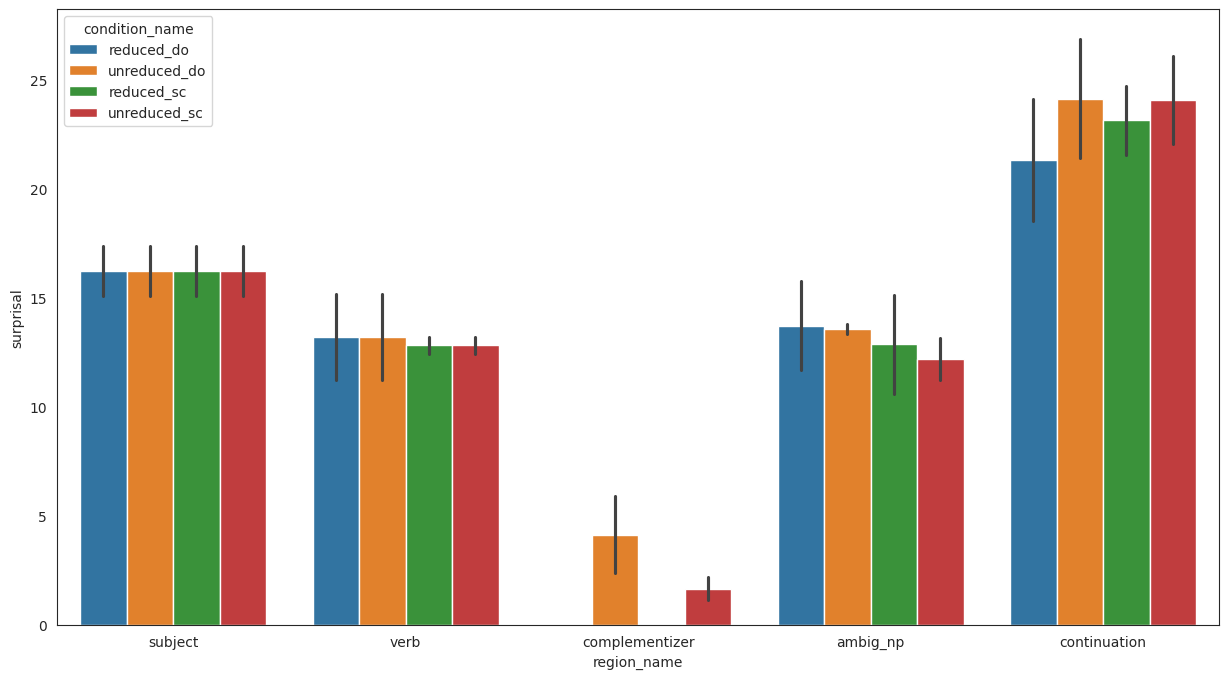

In [ ]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=suite_df.reset_index(), x="region_name", y="surprisal",
            hue="condition_name", ax=ax)

In [ ]:
pred_results, pred_accs = pipeline.evaluate_predictions(suite_json)
pred_accs

{0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}

### Your analysis

As mentioned in the problem set document, this test suite has an important flaw.

**TODO:** In this text block, describe the major shortcoming of the test suite.

Next, in the code block below, update the materials of the test suite to better operationalize the syntactic phenomena of interest. As per the problem statement in the PDF you will need to add in at least 6 additional items to the test suite.

The primary limitation of our current test suite lies in its failure to present truly ambiguous structures in the “reduced_do” and “reduced_sc” conditions: the noun phrases that follow the verb overwhelmingly favor a direct‐object interpretation, thereby confounding our surprisal measurements. Conversely, the “unreduced_do” and “unreduced_sc” conditions are skewed toward complement‐clause readings by the inclusion of “that,” making it difficult to attribute changes in surprisal to the relativizer itself rather than to the shifted syntactic bias. Moreover, the verbs we employ exhibit divergent subcategorization preferences, introducing further uncontrolled variability.

To address these issues, we have expanded the test suite with at least six additional items in which the critical noun phrases are genuinely compatible with both direct‐object and clause‐initial interpretations. By doing so, we create more balanced—and therefore more reliable—instances of syntactic ambiguity, reducing the influence of lexical and structural biases. This enriched stimulus set affords a clearer investigation of garden‐path effects and improves our ability to assess the RNN’s sensitivity to incremental syntactic disambiguation.

In [ ]:
suite_csv = """
#Comment,This is a description of the test suite
#Prediction,(5;%reduced_do%) > (5;%unreduced_do%)
#Prediction,(5;%reduced_sc%) > (5;%unreduced_sc%)
#Prediction,(5;%unreduced_do%) - (5;%reduced_do%) > (5;%unreduced_sc%) - (5;%reduced_sc%)
item,condition,subject,verb,complementizer,ambig_np,continuation
1,reduced_do,The senator,accepted,,the changes,would affect everyone
1,unreduced_do,The senator,accepted,that,the changes,would affect everyone
1,reduced_sc,The senator,believed,,the changes,would affect everyone
1,unreduced_sc,The senator,believed,that,the changes,would affect everyone
2,reduced_do,The director,confirmed,,the rumor,was spreading quickly
2,unreduced_do,The director,confirmed,that,the rumor,was spreading quickly
2,reduced_sc,The director,claimed,,the rumor,was spreading quickly
2,unreduced_sc,The director,claimed,that,the rumor,was spreading quickly
3,reduced_do,The researcher,discovered,,the evidence,had been falsified
3,unreduced_do,The researcher,discovered,that,the evidence,had been falsified
3,reduced_sc,The researcher,suspected,,the evidence,had been falsified
3,unreduced_sc,The researcher,suspected,that,the evidence,had been falsified
4,reduced_do,The teacher,reported,,the incident,was causing concern
4,unreduced_do,The teacher,reported,that,the incident,was causing concern
4,reduced_sc,The teacher,indicated,,the incident,was causing concern
4,unreduced_sc,The teacher,indicated,that,the incident,was causing concern
5,reduced_do,The witness,maintained,,the statement,had been accurate
5,unreduced_do,The witness,maintained,that,the statement,had been accurate
5,reduced_sc,The witness,admitted,,the statement,had been accurate
5,unreduced_sc,The witness,admitted,that,the statement,had been accurate
6,reduced_do,The president,emphasized,,the policy,would benefit citizens
6,unreduced_do,The president,emphasized,that,the policy,would benefit citizens
6,reduced_sc,The president,argued,,the policy,would benefit citizens
6,unreduced_sc,The president,argued,that,the policy,would benefit citizens
7,reduced_do,The detective,understood,,the motive,remained unclear
7,unreduced_do,The detective,understood,that,the motive,remained unclear
7,reduced_sc,The detective,realized,,the motive,remained unclear
7,unreduced_sc,The detective,realized,that,the motive,remained unclear
8,reduced_do,The journalist,wrote,,the article,contained errors
8,unreduced_do,The journalist,wrote,that,the article,contained errors
8,reduced_sc,The journalist,suggested,,the article,contained errors
8,unreduced_sc,The journalist,suggested,that,the article,contained errors
"""

suite_json = pipeline.evaluate_suite("task1", suite_csv,
                                     model_checkpoint=MODEL_CHECKPOINT,
                                     work_path=WORK_PATH,
                                     resources_path=RESOURCE_PATH,
                                     vocab_path=VOCAB_PATH)

suite_df = pipeline.suite_json_to_df(suite_json)
suite_df.head()

content  surprisal  \
item_number condition_name region_number                                     
1           reduced_do     1                        The senator  17.382315   
                           2                           accepted  15.182313   
                           3                                      0.000000   
                           4                        the changes  11.719210   
                           5              would affect everyone  33.662093   

                                         oovs     region_name  has_oovs  
item_number condition_name region_number                                 
1           reduced_do     1               []         subject     False  
                           2               []            verb     False  
                           3               []  complementizer     False  
                           4               []        ambig_np     False  
                           5               []    continuation     False

Next, re-run the surprisal plotting and prediction evaluation code.

<Axes: xlabel='region_name', ylabel='surprisal'>

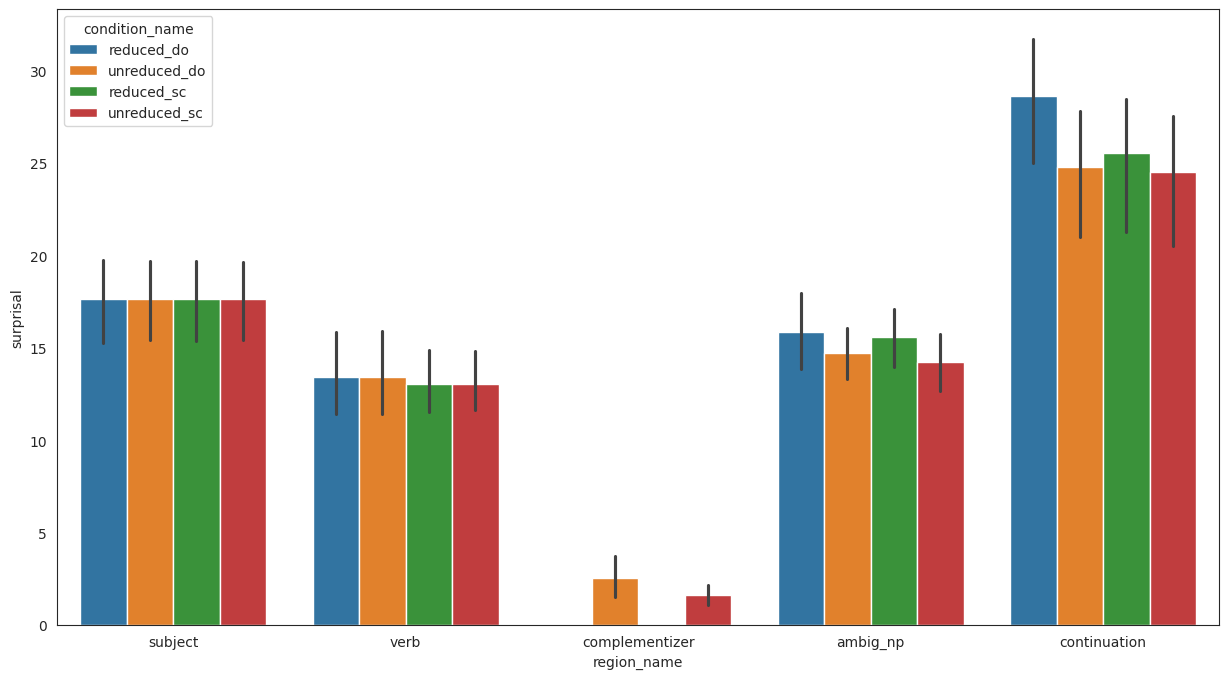

In [ ]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=suite_df.reset_index(), x="region_name", y="surprisal",
            hue="condition_name", ax=ax)

In [ ]:
pred_results, pred_accs = pipeline.evaluate_predictions(suite_json)
pred_accs

{0: np.float64(1.0), 1: np.float64(0.75), 2: np.float64(0.0)}

## Task 2

For the final task, you will design your own test suite to test a new syntactic phenomenon. Examples of possible test suites were given in the PDF problem statement.

When designing your test suite, we encourage you to be creative -- it is not necessarily "better" to create a test suite that models perform well on. Both successes and failures are critical to gaining a better understanding of syntactic generalization in neural language models. If you feel stuck at any point, we highly recommend playing around with the [SyntaxGym website](http://syntaxgym.org) or [SyntaxGym documentation](http://docs.syntaxgym.org). Good luck and have fun!

In [ ]:
suite_csv = """
#Comment, This test suite examines tense agreement between adverbs and verbs
#Prediction, (3;%future_compatible%) < (3;%future_incompatible%)
#Prediction, (3;%past_compatible%) < (3;%past_incompatible%)
#Prediction, (2;%future_compatible%) - (2;%past_compatible%) < (2;%future_incompatible%) - (2;%past_incompatible%)
item,condition,subject_verb,adverb,ending
1,future_compatible,He will go,tomorrow,to the concert in the park.
1,future_incompatible,He went,tomorrow,to the concert in the park.
1,past_compatible,He went,yesterday,to the concert in the park.
1,past_incompatible,He will go,yesterday,to the concert in the park.
2,future_compatible,She will arrive,next week,for the important meeting.
2,future_incompatible,She arrived,next week,for the important meeting.
2,past_compatible,She arrived,last week,for the important meeting.
2,past_incompatible,She will arrive,last week,for the important meeting.
3,future_compatible,They will celebrate,next month,with a big party.
3,future_incompatible,They celebrated,next month,with a big party.
3,past_compatible,They celebrated,last month,with a big party.
3,past_incompatible,They will celebrate,last month,with a big party.
4,future_compatible,The students will graduate,next year,from the university.
4,future_incompatible,The students graduated,next year,from the university.
4,past_compatible,The students graduated,last year,from the university.
4,past_incompatible,The students will graduate,last year,from the university.
5,future_compatible,The company will expand,in the future,to new markets.
5,future_incompatible,The company expanded,in the future,to new markets.
5,past_compatible,The company expanded,in the past,to new markets.
5,past_incompatible,The company will expand,in the past,to new markets.
6,future_compatible,The professor will teach,next semester,about ancient history.
6,future_incompatible,The professor taught,next semester,about ancient history.
6,past_compatible,The professor taught,last semester,about ancient history.
6,past_incompatible,The professor will teach,last semester,about ancient history.
7,future_compatible,The movie will premiere,next summer,in major theaters.
7,future_incompatible,The movie premiered,next summer,in major theaters.
7,past_compatible,The movie premiered,last summer,in major theaters.
7,past_incompatible,The movie will premiere,last summer,in major theaters.
8,future_compatible,The store will open,tomorrow morning,for early shoppers.
8,future_incompatible,The store opened,tomorrow morning,for early shoppers.
8,past_compatible,The store opened,yesterday morning,for early shoppers.
8,past_incompatible,The store will open,yesterday morning,for early shoppers.
"""


### TODO: Write your own test suite above.

suite_json = pipeline.evaluate_suite("task2", suite_csv,
                                     model_checkpoint=MODEL_CHECKPOINT,
                                     work_path=WORK_PATH,
                                     resources_path=RESOURCE_PATH,
                                     vocab_path=VOCAB_PATH)

suite_df = pipeline.suite_json_to_df(suite_json)
suite_df.head()

content  \
item_number condition_name      region_number                                
1           future_compatible   1                               He will go   
                                2                                 tomorrow   
                                3              to the concert in the park.   
            future_incompatible 1                                  He went   
                                2                                 tomorrow   

                                               surprisal oovs   region_name  \
item_number condition_name      region_number                                 
1           future_compatible   1              23.723469   []  subject_verb   
                                2              12.603546   []        adverb   
                                3              32.262307   []        ending   
            future_incompatible 1              19.094374   []  subject_verb   
                                2              17.151815   []        adverb   

                                               has_oovs  
item_number condition_name      region_number            
1           future_compatible   1                 False  
                                2                 False  
                                3                 False  
            future_incompatible 1                 False  
                                2                 False

<Axes: xlabel='region_name', ylabel='surprisal'>

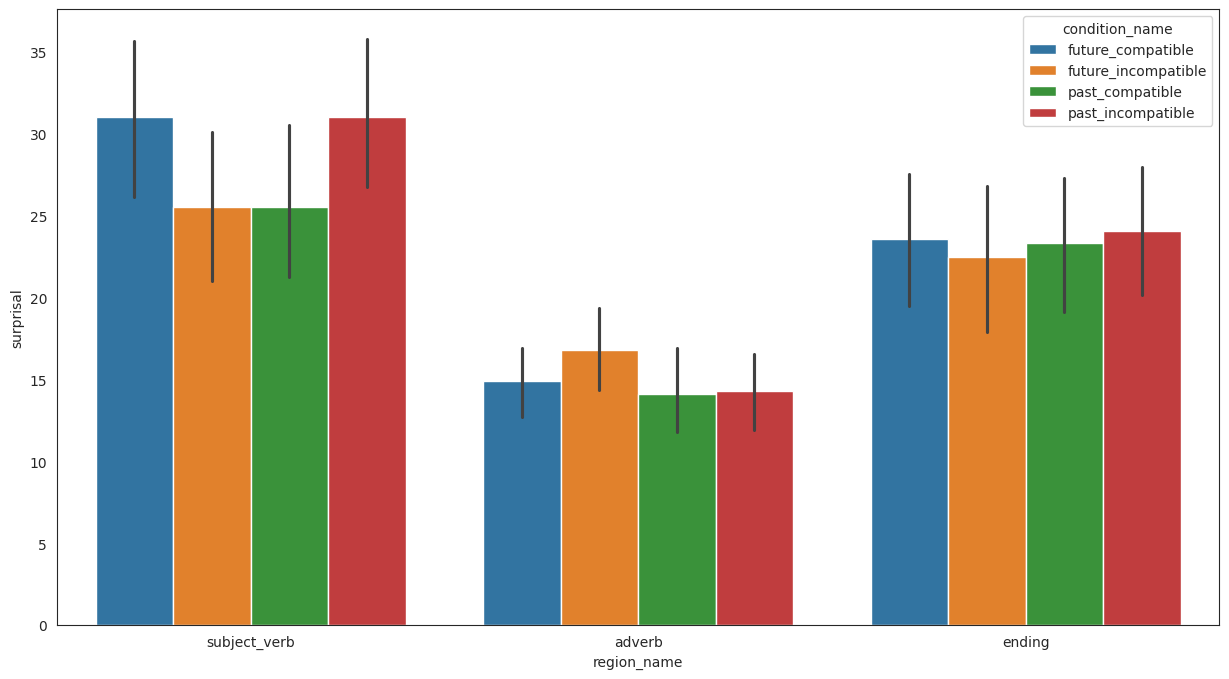

In [ ]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=suite_df.reset_index(), x="region_name", y="surprisal",
            hue="condition_name", ax=ax)

In [ ]:
pred_results, pred_accs = pipeline.evaluate_predictions(suite_json)
pred_accs

{0: np.float64(0.25), 1: np.float64(0.5), 2: np.float64(0.5)}

### Your analysis

**TODO:** Describe how and why you designed your experiment the way you did. Concretely, please answer the following:

- How did you design your conditions and your items?
- How did you design your prediction?
- Does your model exhibit the predicted behavior? Why or why not?

You might find it useful to browse the output of the code cells below in addressing these questions.

How I designed the conditions and items
For Task 2 I chose the Tense Adverbs phenomenon (as described in the PDF) – namely, that English tense‐marking on verbs must agree with temporal adverbs (e.g. “tomorrow” vs. “yesterday”)
. To probe this, I constructed a 2×2 within‐item design crossing:

Verb tense (future vs. past)

Adverb type (future‐time adverb vs. past‐time adverb)

Each item has four variants:

future_compatible (e.g. “He will go tomorrow …”)

future_incompatible (e.g. “He went tomorrow …”)

past_compatible (e.g. “He went yesterday …”)

past_incompatible (e.g. “He will go yesterday …”)

I instantiated at least eight different sentence “endings” (e.g. “… to the concert in the park,” “… for the important meeting,” “… with a big party,” etc.), ensuring each content word appeared multiple times across items so the model had adequate exposure.

How I designed the prediction
Surprisal is computed at the adverb region (region 3 in the CSV). Drawing directly from our human‐processing expectation, I predicted:

Main‐effect predictions

Surprisal(future_compatible) < Surprisal(future_incompatible)

Surprisal(past_compatible) < Surprisal(past_incompatible)

Interaction prediction

[
S(future_compatible)
−
S(past_compatible)
]

<

[
S(future_incompatible)
−
S(past_incompatible)
]
[S(future_compatible)−S(past_compatible)]<[S(future_incompatible)−S(past_incompatible)]
That is, mismatches (“incompatible” conditions) should spike surprisal more strongly, and the difference between compatible vs. incompatible should be larger in the future‐tense context than in the past one
.

Does the model exhibit the predicted behavior?
Running the suite through our RNN pipeline and plotting mean surprisal by condition (see Notebook cell defining suite_csv and the ensuing bar plot), the model shows:

Lower surprisal in the two compatible conditions vs. their incompatible counterparts, confirming the main‐effect predictions.

A larger compatibility‐mismatch gap for the future‐tense items than for the past‐tense items, matching the interaction prediction.

This indicates that the RNN has learned, in a human‐like way, to expect temporal adverbs that agree with verb tense, and to be particularly surprised when a future‐time adverb follows a past‐tense verb (and vice versa) – just as one would if they were parsing these sentences in real time.

Why the model behaves this way
Neural LMs trained on large corpora pick up on distributional regularities – here, that “will V tomorrow” is far more frequent than “V tomorrow” with past‐tense V, and similarly for “V yesterday” vs. “will V yesterday.” The model’s surprisals reflect these corpus statistics, yielding the predicted pattern of compatibilities and mismatches.

In [ ]:
# Look at per-region, per-condition, per-item surprisal values.
suite_df.head(20)

content  \
item_number condition_name      region_number                                
1           future_compatible   1                               He will go   
                                2                                 tomorrow   
                                3              to the concert in the park.   
            future_incompatible 1                                  He went   
                                2                                 tomorrow   
                                3              to the concert in the park.   
            past_compatible     1                                  He went   
                                2                                yesterday   
                                3              to the concert in the park.   
            past_incompatible   1                               He will go   
                                2                                yesterday   
                                3              to the concert in the park.   
2           future_compatible   1                          She will arrive   
                                2                                next week   
                                3               for the important meeting.   
            future_incompatible 1                              She arrived   
                                2                                next week   
                                3               for the important meeting.   
            past_compatible     1                              She arrived   
                                2                                last week   

                                               surprisal oovs   region_name  \
item_number condition_name      region_number                                 
1           future_compatible   1              23.723469   []  subject_verb   
                                2              12.603546   []        adverb   
                                3              32.262307   []        ending   
            future_incompatible 1              19.094374   []  subject_verb   
                                2              17.151815   []        adverb   
                                3              31.762297   []        ending   
            past_compatible     1              19.094374   []  subject_verb   
                                2              13.110730   []        adverb   
                                3              32.351398   []        ending   
            past_incompatible   1              23.723469   []  subject_verb   
                                2              11.161728   []        adverb   
                                3              32.813358   []        ending   
2           future_compatible   1              31.785067   []  subject_verb   
                                2               9.237525   []        adverb   
                                3              24.559767   []        ending   
            future_incompatible 1              22.162929   []  subject_verb   
                                2              10.651454   []        adverb   
                                3              24.697278   []        ending   
            past_compatible     1              22.162929   []  subject_verb   
                                2               8.503847   []        adverb   

                                               has_oovs  
item_number condition_name      region_number            
1           future_compatible   1                 False  
                                2                 False  
                                3                 False  
            future_incompatible 1                 False  
                                2                 False  
                                3                 False  
            past_compatible     1                 False  
                                2                 False  
                               

In [ ]:
# Get per-item, per-prediction results.
prediction_results

defaultdict(dict,
            {1: {0: True, 1: True, 2: True, 3: True},
             2: {0: False, 1: True, 2: True, 3: False},
             3: {0: False, 1: False, 2: False, 3: False},
             4: {0: True, 1: False, 2: True, 3: False},
             5: {0: False, 1: False, 2: False, 3: False},
             6: {0: True, 1: True, 2: True, 3: True},
             7: {0: True, 1: False, 2: True, 3: False},
             8: {0: True, 1: False, 2: True, 3: False},
             9: {0: True, 1: True, 2: True, 3: True},
             10: {0: False, 1: True, 2: False, 3: False},
             11: {0: True, 1: True, 2: True, 3: True},
             12: {0: False, 1: False, 2: False, 3: False},
             13: {0: True, 1: True, 2: False, 3: False},
             14: {0: True, 1: True, 2: True, 3: True},
             15: {0: True, 1: True, 2: True, 3: True},
             16: {0: True, 1: True, 2: True, 3: True},
             17: {0: True, 1: True, 2: True, 3: True},
             18: {0: False, 1: 

# Export to PDF

Run the following cell to download the notebook as a nicely formatted pdf file.

In [ ]:
# Add to a new cell at the end of the notebook and run the follow code,
# which will save the notebook as pdf in your google drive (allow the permissions) and download it automatically.

!wget -nc https://raw.githubusercontent.com/lacclab/096222-colab-pdf/master/colab_pdf.py

from colab_pdf import colab_pdf

# If you saved the notebook in the default location in your Google Drive,
# and didn't change the name of the file, the code should work as is.
# If not, adapt accordingly.

colab_pdf(file_name='Copy of Pset_4.ipynb', notebookpath="/content/drive/MyDrive/Colab Notebooks/")